---
# Tweet Emotion Classifier
---

Files needed:
* Lastest json file with all tweets from all cities (e.g. {time_stamp}_all_cities.json)

## Installs and Imports

In [1]:
# Install PySpark and Spark NLP
! pip install -q pyspark==3.1.2 spark-nlp

In [2]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')

#select seaborn color palette
sns.set_palette('ocean_r')

## Modeling

In [3]:
# start spark session
spark = sparknlp.start()

# read in data
# df = spark.read.json('2022-03-01_21-24-03_all_cities.json')
df = spark.read.json('data/2022-03-01_21-24-03/2022-03-01_21-24-03_all_cities.json')

# define spark nlp pipeline
document_assembler = DocumentAssembler() \
    .setInputCol('full_text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

sequenceClassifier = BertForSequenceClassification \
      .pretrained('bert_sequence_classifier_emotion', 'en') \
      .setInputCols(['token', 'document']) \
      .setOutputCol('class')

pipeline = Pipeline(stages=[document_assembler, tokenizer, sequenceClassifier])

# run the pipeline
result = pipeline.fit(df).transform(df)

bert_sequence_classifier_emotion download started this may take some time.
Approximate size to download 391.1 MB
[OK!]


In [4]:
# rename the class column
result = result.withColumnRenamed('class', 'sentiment')

In [6]:
# pull out emotion from embedded column and select columns of interest
final_df = result.withColumn('emotion', result.sentiment.result[0]).select('created_at', 'city', 'full_text', 'sentiment_score', 'emotion')

In [7]:
%%time
# save as pandas df
final_df_pd = final_df.toPandas()

CPU times: user 73.1 ms, sys: 94.3 ms, total: 167 ms
Wall time: 8min 40s


In [10]:
# generate time stamp
time_stamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
!mkdir 'data/{time_stamp}'
# save final data
# final_df_pd.to_json(f'{time_stamp}_final22.json', orient='records')
final_df_pd.to_json(f'data/{time_stamp}/{time_stamp}_final22.json', orient='records')

In [11]:
# # read data in (if starting with flat data with emotion labels)
# final_df = spark.read.json(f'{time_stamp}_final22.json')
# final_df_pd = final_df.toPandas()

## Visualize Results

In [12]:
emotion_ct = pd.crosstab(final_df_pd.city, final_df_pd.emotion, margins=True)

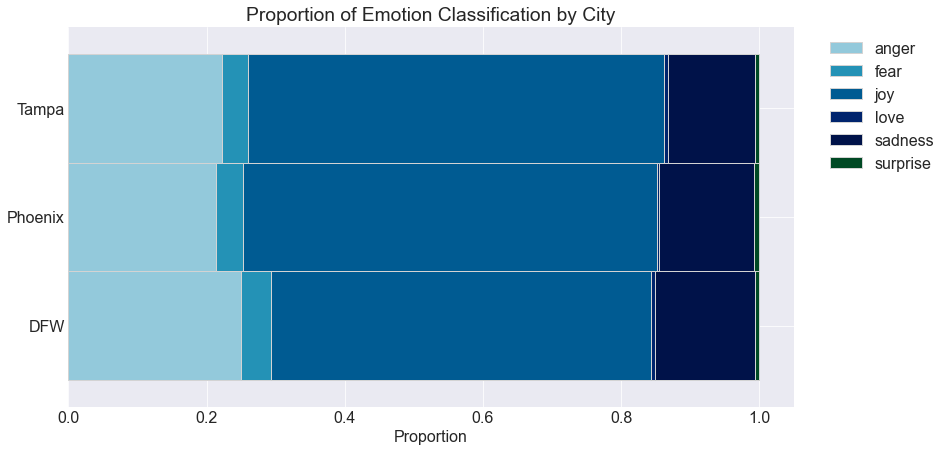

In [13]:
city_list = ['DFW', 'Phoenix', 'Tampa']
(emotion_ct[emotion_ct.index.isin(city_list)]
  .apply(lambda row: row/row['All'], axis = 1)
  .drop(columns = 'All')
  .plot.barh(stacked = True, width = 1, ec = 'lightgrey')
)
plt.title('Proportion of Emotion Classification by City')
plt.legend(bbox_to_anchor= (1.03,1))
plt.xlabel('Proportion')
plt.ylabel('');

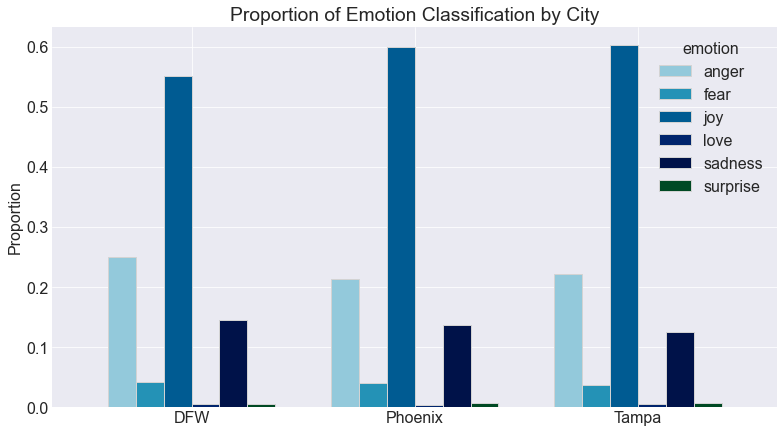

In [14]:
city_list = ['DFW', 'Phoenix', 'Tampa']
(emotion_ct[emotion_ct.index.isin(city_list)]
  .apply(lambda row: row/row['All'], axis = 1)
  .drop(columns = 'All')
  .plot.bar(width=0.75, ec='lightgray')
)
plt.title('Proportion of Emotion Classification by City')
plt.xlabel('')
plt.ylabel('Proportion')
plt.xticks(rotation=0);
# plt.legend(bbox_to_anchor= (1.03,1));